# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import glob

# File reading

## Set source directory and prepare arrays

In [3]:
#this just allows easy folder selection so you don't have to copy the name from the file browser

folders = glob.glob("*_map")

for i in range(0, len(folders)):
    print("{0:>2d} - {1:s} - {2}".format(i, folders[i], len(glob.glob(folders[i]+"/*.spx"))))

 0 - 20230531_CVD_3076_map - 200
 1 - 20230531_CVD_3158_map - 200
 2 - 20230606_CVD_2555_map - 200
 3 - 20230607_CVD_2546_map - 200
 4 - 20230607_CVD_2802_map - 200
 5 - 20230613_CVD_2808_map - 200
 6 - 20230621_CVD_2808_map - 800
 7 - 20230623_CVD_2566_map - 200
 8 - 20230626_CVD_2808_map - 800
 9 - 20230627_CVD_2546_map - 800
10 - 20230628_CVD_2546_map - 800
11 - 20230711_CVD_2546_map - 800


In [4]:
path_label = folders[8][0:-4]

sample_name = "CVD" + path_label[-4:]

In [5]:
#set number of points and dimensions of scan
#grid_size is number of steps in the grid x and y axes
#grid_dim is the actual length of the sides of the square scanned by the grid, in mm

if len(glob.glob("./"+path_label+"_map/*.spx")) == 200:
    grid_size = 10
    grid_dim = 15
elif len(glob.glob("./"+path_label+"_map/*.spx")) == 800:
    grid_size = 20
    grid_dim = 0.5
else:
    raise FileNotFoundError("Folder contains neither 200 nor 800 .spx files.")

print("{0}x{0} grid".format(grid_size))

#dat["Xx_Yy_dZ"] contains data from element Xx, characteristic line Yy, detector Z
dat = {
    "Si_ka_d1": np.zeros((grid_size, grid_size)),
    "Si_ka_d2": np.zeros((grid_size, grid_size)),
    "Ga_ka_d1": np.zeros((grid_size, grid_size)),
    "Ga_ka_d2": np.zeros((grid_size, grid_size)),
    "Ga_kb_d1": np.zeros((grid_size, grid_size)),
    "Ga_kb_d2": np.zeros((grid_size, grid_size)),
    "Ga_l_d1":  np.zeros((grid_size, grid_size)),
    "Ga_l_d2":  np.zeros((grid_size, grid_size)),
    "P_ka_d1":  np.zeros((grid_size, grid_size)),
    "P_ka_d2":  np.zeros((grid_size, grid_size))
}

20x20 grid


## Counts data from PyMca

In [7]:
source = "PyMca"

#glob can be used here because there is only one csv file, and it is useful in case the file name format changes
input_file = open(glob.glob("./" + path_label + "_map/fits_out/IMAGES/*.csv")[0], "r")

s = input_file.readline().split(";")

while s != [""]:
    
    #only read lines that start with a number
    #also, only read lines in column zero. When PyMca does batch fits on .spx
    #files, it will interpret the SNIP background from the bruker software as
    #its own spectrum, and fit both the actual spectrum and the background as
    #though they were both spectra. When it does this, the csv file contains
    #peak areas from the actual spectrum in column 0, and peak areas from the
    #background in column 1.
    if s[0][0].isnumeric() and s[1] == "0": 
        
        index = int(s[0]) #file index is first in the line
        x = int(((index)/grid_size) % grid_size)
        y = int((index) % grid_size)
        
        si_counts = float(s[2])
        ga_ka_counts = float(s[8])
        ga_kb_counts = float(s[9])
        #combine data from La1, La2, La3 since they are indistuinguishable with Si(Li) detector
        ga_l_counts = float(s[10]) + float(s[11]) + float(s[12])
        p_counts = float(s[4])
        
        if int(s[0]) < grid_size**2 : #separate into detector 1 and detector 2
            dat["Si_ka_d1"][y][x] = si_counts
            dat["Ga_ka_d1"][y][x] = ga_ka_counts
            dat["Ga_kb_d1"][y][x] = ga_kb_counts
            dat["Ga_l_d1"][y][x] = ga_l_counts
            dat["P_ka_d1"][y][x] = p_counts
            
        elif int(s[0]) >= grid_size**2:
            dat["Si_ka_d2"][y][x] = si_counts
            dat["Ga_ka_d2"][y][x] = ga_ka_counts
            dat["Ga_kb_d2"][y][x] = ga_kb_counts
            dat["Ga_l_d2"][y][x] = ga_l_counts
            dat["P_ka_d2"][y][x] = p_counts

    s = input_file.readline().split(";")
        
input_file.close()

## Dead/real time data

In [11]:
file_list = glob.glob("./" + path_label + "_map/*.spx")

# Plotting

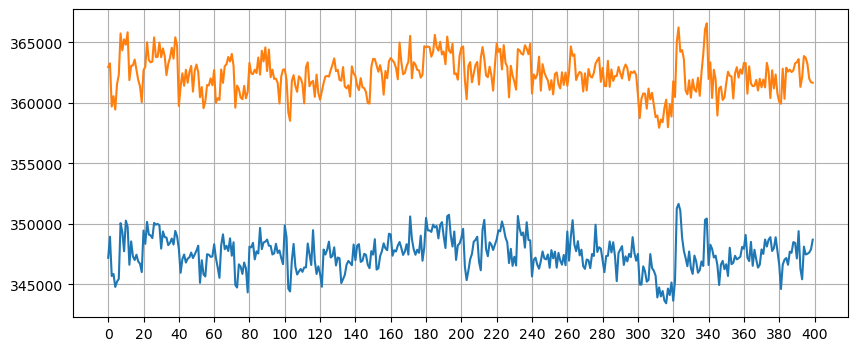

In [10]:
#fortran order: first index changes fastest
#in the data reading cell, y is written to the first index
#the scan proceeds with y changing fastest
#so this matches the order in which the points are collected
vec1 = np.reshape(dat["Si_ka_d1"], 400, order="F")
vec2 = np.reshape(dat["Si_ka_d2"], 400, order="F")

f, ax = plt.subplots(figsize=(10,4))
ax.plot(vec1)
ax.plot(vec2)
ax.grid(True)

ax.set_xticks(np.arange(0, 420, 20))
plt.show()